In [ ]:
pip install mediapipe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 13.5 MB/s eta 0:00:00


In [ ]:
import cv2
import numpy as np
import tensorflow as tf
import mediapipe as mp
from google.colab.patches import cv2_imshow

In [ ]:
# Load the trained model (expects input shape (None, 224, 224, 3) if using transfer learning pipeline)
model = tf.keras.models.load_model("abc.keras")
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Mapping of class indices to labels (update as needed)
class_indices = {
    'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7,
    'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14,
    'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21,
    'W': 22, 'X': 23, 'Y': 24, 'Z': 25, 'del': 26, 'nothing': 27, 'space': 28
}
labels = {v: k for k, v in class_indices.items()}

# Initialize MediaPipe Hands (for static image processing)
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(
    static_image_mode=True,  # Process one image at a time
    max_num_hands=1,
    min_detection_confidence=0.5
)


In [ ]:
def crop_hand(image):
    """Uses MediaPipe to detect and crop the hand region from an image."""
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = hands.process(image_rgb)
    if results.multi_hand_landmarks:
        h, w, _ = image.shape
        landmarks = results.multi_hand_landmarks[0].landmark
        xs = [lm.x for lm in landmarks]
        ys = [lm.y for lm in landmarks]
        xmin = int(min(xs) * w)
        xmax = int(max(xs) * w)
        ymin = int(min(ys) * h)
        ymax = int(max(ys) * h)
        padding = 20  # Optional padding
        xmin = max(0, xmin - padding)
        ymin = max(0, ymin - padding)
        xmax = min(w, xmax + padding)
        ymax = min(h, ymax + padding)
        return image[ymin:ymax, xmin:xmax]
    else:
        return image  # Return the original if no hand is detected

def predict_image(image_path, target_size=(224,224)):
    """Loads an image, extracts the hand region, processes it, and predicts the class."""
    # Load image from file
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError("Image not found at: " + image_path)

    # Make a copy for annotation
    annotated_image = image.copy()

    # Crop hand region using MediaPipe
    cropped = crop_hand(image)

    # Resize to target_size and normalize pixel values
    processed = cv2.resize(cropped, target_size)
    processed = processed.astype('float32') / 255.0
    processed = np.expand_dims(processed, axis=0)

    # Predict the class
    predictions = model.predict(processed)
    predicted_class = np.argmax(predictions[0])
    prediction_text = labels.get(predicted_class, "Unknown")

    # Annotate the image with the predicted label
    cv2.putText(annotated_image, prediction_text, (50, 50),
                cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 255), 3)

    return prediction_text, annotated_image



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted Label: P


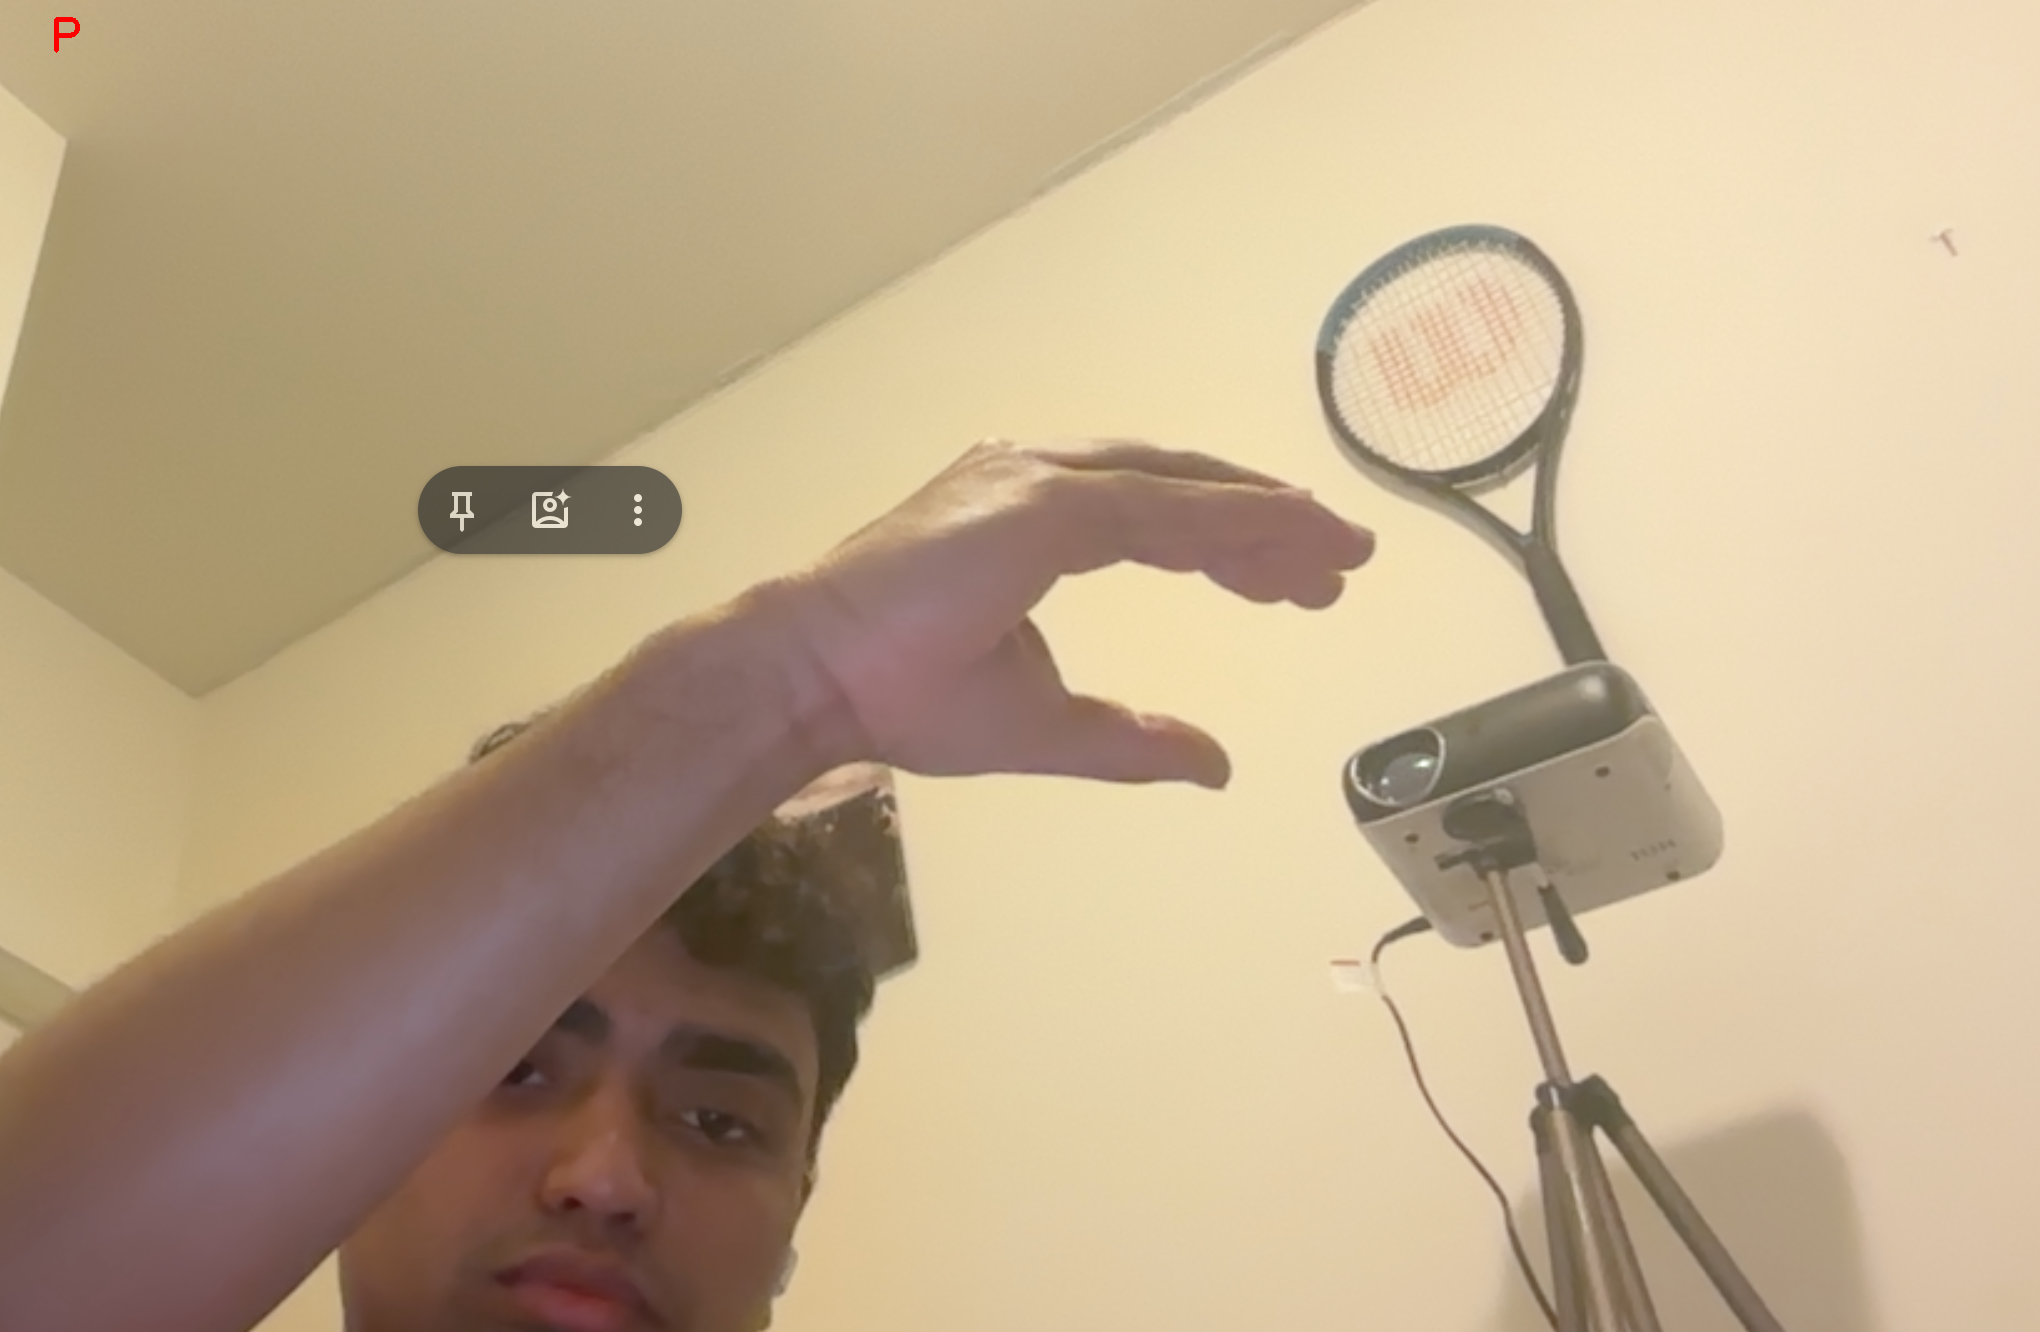

In [ ]:
# Example usage:
image_path = "test.png"  # Replace with your image path
predicted_label, annotated = predict_image(image_path)
print("Predicted Label:", predicted_label)
cv2_imshow(annotated)

# Clean up MediaPipe resources
hands.close()